In [2]:
import os 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy 

In [21]:
def combineCSVs(datafolder):
    """
    Combine all participant data into one pandas df
    OR 
    Create df for single participant file 
    """
    #checks if path is a file
    isFile = os.path.isfile(datafolder)

    #checks if path is a directory
    
    isDirectory = os.path.isdir(datafolder)
    
    if isDirectory == True:
        data = []
        for filename in os.listdir(datafolder):
            if 'csv' in filename:
                path = datafolder + "/" + filename
                df = pd.read_csv(path, index_col=None, header=0)
                # ONLY for test data NOT for actual 
        #         noNan_df = df[:10] 
        #         data.append(noNan_df)
                # uncomment line below for ACTUAL data 
                data.append(df)

        input_frame = pd.concat(data, axis=0, ignore_index=True)
        
    if isFile == True:
        if 'csv' in datafolder:
            input_frame = pd.read_csv(datafolder, index_col=None, header=0)
 
    return input_frame


def feet_to_meters(ft):
    """
    Args: 
        ft = float value in feet 
        
    returns:
        m = float value converted to meters 
    """
    m = ft * 0.3048
    return m

def getUnitConveredData(datafolder):
    input_data = combineCSVs(datafolder) # combine CSVs from all participants 
    
    for idx, row in input_data.iterrows():
        unit = row['unitSelection']
        # if estimate was made in feet, convert to meters 
        if unit == 'feet':
            estim_ft = row['depth_estimate']
            estim_m = feet_to_meters(estim_ft)
            # update depth estimates in existing dataframe
            input_data.at[idx, 'depth_estimate'] = estim_m
            # update units in existing dataframe
#             input_data.at[idx, 'unitSelection'] = 'meters'
    
    return input_data

def cleanAgeResponses(datafolder):
    input_data = getUnitConveredData(datafolder)
    
    for idx, row in input_data.iterrows():
        age = row['age']
        # if year of birth was given, convert to age
        if age > 100:
            actual_age = 2021-age
            # update age in existing dataframe
            input_data.at[idx, 'age'] = actual_age
        # participants must be over 18 so age reports below 18 are junk 
        if age < 18:
            actual_age = None
            # update age in existing dataframe
            input_data.at[idx, 'age'] = actual_age    
        if 90 < age < 100:
            actual_age = None
            # update age in existing dataframe
            input_data.at[idx, 'age'] = actual_age 
    
    return input_data    
    

def removeMissedTrials(datafolder):
    """
    Participants were told that if they missed a trial, to respond '0'.
    This function removes those trials, and keeps track of:
    (1) How many missed trials per participant
    (2) Number of missed trials per duration 
    (3) Number of missed trials per sequence 
    """
    input_data = cleanAgeResponses(datafolder)
    
    missedTrials_participants = {}
    missedTrials_durations = {}
    missedTrials_sequences = {}
    
    
    for idx, row in input_data.iterrows():
        estimate = row['depth_estimate']
        if estimate == 0.0:
            subjID = row['subjID']
            duration = row['duration']
            sequenceName = row['sequenceName']
            
            if subjID not in missedTrials_participants:
                missedTrials_participants[subjID] = 1
            else:
                missedTrials_participants[subjID] += 1

            if duration not in missedTrials_durations:
                missedTrials_durations[duration] = 1
            else:
                missedTrials_durations[duration] += 1
            
            if sequenceName not in missedTrials_sequences:
                missedTrials_sequences[sequenceName] = 1
            else:
                missedTrials_sequences[sequenceName] += 1
            
#             print(subjID, duration, sequenceName)
            
            # remove trials with depth estimate = 0 
            input_data.drop(idx, inplace=True)
    
    # remove participants data if the participant's missed trial count is 10% or more of num_trials
    threshold = math.floor(192 * 0.1)
#     print("Missing Trial Count Threshold: ", threshold)
    remove_ids = []
    for key in missedTrials_participants:
        if missedTrials_participants[key] >= threshold:
            remove_ids.append(key)
    print("Number of participants with 10% or more missed trials: ", len(remove_ids))

    for index, row in input_data.iterrows():
        if row['subjID'] in remove_ids:
            input_data.drop(index, inplace=True)

    # Note if a particular participant, duration, or sequence has maximum missing trials
    # ** If the participant had no missed trials, then ID will not show up in dict 
#     print("Missed Trials")
#     print(missedTrials_participants)
#     print(missedTrials_durations)
#     print(missedTrials_sequences)

    
    return input_data

In [22]:
path = '/Users/prachi/Documents/depth_duration/analysis/data'

missed_trial_cleaned_data = removeMissedTrials(path)

Number of participants with 10% or more missed trials:  20


In [23]:
missed_trial_cleaned_data

,subjID,experimentName,versionName,sequenceName,url,selected_row,windowWidth,windowHeight,screenWidth,screenHeight,...,stimulus,duration,actual_depth,depth_estimate,trial_RT,log_sceneDuration,unitSelection,experimentTime,totalTime,age
0,926651,DepthScenes,duration_manipulation,ad,http://54.165.233.113/DepthDuration/depth_dura...,14,1536,691,1536,864,...,depth_duration_stimuli/002425_2014-06-28_20-27...,1000,3.8960,1.2192,6144,1005,feet,1140442,1342135,41.0
1,926651,DepthScenes,duration_manipulation,ad,http://54.165.233.113/DepthDuration/depth_dura...,14,1536,691,1536,864,...,depth_duration_stimuli/000720_2014-06-08_18-37...,750,1.5580,0.3048,5723,760,feet,1140442,1342135,41.0
3,926651,DepthScenes,duration_manipulation,ad,http://54.165.233.113/DepthDuration/depth_dura...,14,1536,691,1536,864,...,depth_duration_stimuli/002725_2014-06-22_11-47...,1000,2.1950,0.9144,4429,1001,feet,1140442,1342135,41.0
4,926651,DepthScenes,duration_manipulation,ad,http://54.165.233.113/DepthDuration/depth_dura...,14,1536,691,1536,864,...,depth_duration_stimuli/003081_2014-06-15_15-19...,500,3.9125,1.5240,4510,500,feet,1140442,1342135,41.0
5,926651,DepthScenes,duration_manipulation,ad,http://54.165.233.113/DepthDuration/depth_dura...,14,1536,691,1536,864,...,depth_duration_stimuli/002987_2014-06-08_18-48...,250,2.6775,0.6096,3675,259,feet,1140442,1342135,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44731,237650,DepthScenes,duration_manipulation,af,http://184.72.206.71/DepthDuration/depth_durat...,22,1600,900,1600,900,...,depth_duration_stimuli/001808_2014-06-26_20-50...,750,4.2490,2.7432,4171,751,feet,1186107,1344157,67.0
44732,237650,DepthScenes,duration_manipulation,af,http://184.72.206.71/DepthDuration/depth_durat...,22,1600,900,1600,900,...,depth_duration_stimuli/002199_2014-06-28_18-33...,1000,1.9960,0.9144,4044,1000,feet,1186107,1344157,67.0
44733,237650,DepthScenes,duration_manipulation,af,http://184.72.206.71/DepthDuration/depth_durat...,22,1600,900,1600,900,...,depth_duration_stimuli/000788_2014-06-08_22-34...,1000,3.3590,1.8288,4332,1002,feet,1186107,1344157,67.0
44734,237650,DepthScenes,duration_manipulation,af,http://184.72.206.71/DepthDuration/depth_durat...,22,1600,900,1600,900,...,depth_duration_stimuli/000665_2014-06-09_20-42...,250,3.0570,1.8288,3071,238,feet,1186107,1344157,67.0


#### Distribution of Unit Preferences

In [24]:
pre_unitconversion_data = combineCSVs(path)

In [25]:
subject_ids_pre_cleaning = pre_unitconversion_data.subjID.unique()
subj_units = {}
meters_count = 0
feet_count = 0
for subj in subject_ids_pre_cleaning:
    subj_df = pre_unitconversion_data.loc[pre_unitconversion_data['subjID'] == subj]
    unit = subj_df.unitSelection.unique()
    subj_units[subj] = unit[0]
    if unit == "feet":
        feet_count += 1
    if unit == "meters":
        meters_count += 1
    
meters_count, feet_count

(52, 181)

In [26]:

def RT_Cleaning(df):
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    df2_list = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
        # calculate subject's average trial RT 
        average_trial_RT = subj_df["trial_RT"].mean()
        std_trial_RT = subj_df["trial_RT"].std()
#         outlier_range = [(average_trial_RT - (3*std_trial_RT)), (average_trial_RT + (3*std_trial_RT))] 
        outlier_range = [1000, (average_trial_RT + (3*std_trial_RT))] 

        for idx, row in subj_df.iterrows():
            RT = row["trial_RT"]
            if RT < outlier_range[0]: # outlier
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
            if RT > outlier_range[1]:
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
                
        threshold = math.floor(192 * 0.1)
        if count >= threshold:
            remove.append(subj)
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
            
    print("Number of Participants with 10% or more trials outside their RT range: ", len(remove))
    
    for index, row in df2.iterrows():
        if row['subjID'] in remove:
            df2.drop(index, inplace=True)
    
    return df2



In [27]:
RT_cleaned_data = RT_Cleaning(missed_trial_cleaned_data)

Number of Participants with 10% or more trials outside their RT range:  0


In [28]:
RT_cleaned_data

,subjID,experimentName,versionName,sequenceName,url,selected_row,windowWidth,windowHeight,screenWidth,screenHeight,...,stimulus,duration,actual_depth,depth_estimate,trial_RT,log_sceneDuration,unitSelection,experimentTime,totalTime,age
0,926651,DepthScenes,duration_manipulation,ad,http://54.165.233.113/DepthDuration/depth_dura...,14,1536,691,1536,864,...,depth_duration_stimuli/002425_2014-06-28_20-27...,1000,3.8960,1.2192,6144,1005,feet,1140442,1342135,41.0
1,926651,DepthScenes,duration_manipulation,ad,http://54.165.233.113/DepthDuration/depth_dura...,14,1536,691,1536,864,...,depth_duration_stimuli/000720_2014-06-08_18-37...,750,1.5580,0.3048,5723,760,feet,1140442,1342135,41.0
3,926651,DepthScenes,duration_manipulation,ad,http://54.165.233.113/DepthDuration/depth_dura...,14,1536,691,1536,864,...,depth_duration_stimuli/002725_2014-06-22_11-47...,1000,2.1950,0.9144,4429,1001,feet,1140442,1342135,41.0
4,926651,DepthScenes,duration_manipulation,ad,http://54.165.233.113/DepthDuration/depth_dura...,14,1536,691,1536,864,...,depth_duration_stimuli/003081_2014-06-15_15-19...,500,3.9125,1.5240,4510,500,feet,1140442,1342135,41.0
5,926651,DepthScenes,duration_manipulation,ad,http://54.165.233.113/DepthDuration/depth_dura...,14,1536,691,1536,864,...,depth_duration_stimuli/002987_2014-06-08_18-48...,250,2.6775,0.6096,3675,259,feet,1140442,1342135,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44731,237650,DepthScenes,duration_manipulation,af,http://184.72.206.71/DepthDuration/depth_durat...,22,1600,900,1600,900,...,depth_duration_stimuli/001808_2014-06-26_20-50...,750,4.2490,2.7432,4171,751,feet,1186107,1344157,67.0
44732,237650,DepthScenes,duration_manipulation,af,http://184.72.206.71/DepthDuration/depth_durat...,22,1600,900,1600,900,...,depth_duration_stimuli/002199_2014-06-28_18-33...,1000,1.9960,0.9144,4044,1000,feet,1186107,1344157,67.0
44733,237650,DepthScenes,duration_manipulation,af,http://184.72.206.71/DepthDuration/depth_durat...,22,1600,900,1600,900,...,depth_duration_stimuli/000788_2014-06-08_22-34...,1000,3.3590,1.8288,4332,1002,feet,1186107,1344157,67.0
44734,237650,DepthScenes,duration_manipulation,af,http://184.72.206.71/DepthDuration/depth_durat...,22,1600,900,1600,900,...,depth_duration_stimuli/000665_2014-06-09_20-42...,250,3.0570,1.8288,3071,238,feet,1186107,1344157,67.0


In [29]:
def participant_Outlier_Removal(df):
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    remove = []
    
    df2_list = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 

        # calculate subject's average trial RT 
        average = subj_df["depth_estimate"].mean()
        std = subj_df["depth_estimate"].std()
        outlier_range = [(average - (3*std)), (average + (3*std))]
        
        for idx, row in subj_df.iterrows():
            estim = row["depth_estimate"]
            if estim < outlier_range[0]: # outlier
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
            if estim > outlier_range[1]:
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
                
        threshold = math.floor(192 * 0.1)
        if count >= threshold:
            remove.append(subj)
         
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
        
    print("Number of Participants with 10% or more outlier trials: ", len(remove))
    
    for index, row in df2.iterrows():
        if row['subjID'] in remove:
            df2.drop(index, inplace=True)
    
    return df2



In [30]:
outlier_cleaned_data = participant_Outlier_Removal(RT_cleaned_data)

Number of Participants with 10% or more outlier trials:  0


In [31]:
outlier_cleaned_data

,subjID,experimentName,versionName,sequenceName,url,selected_row,windowWidth,windowHeight,screenWidth,screenHeight,...,stimulus,duration,actual_depth,depth_estimate,trial_RT,log_sceneDuration,unitSelection,experimentTime,totalTime,age
0,926651,DepthScenes,duration_manipulation,ad,http://54.165.233.113/DepthDuration/depth_dura...,14,1536,691,1536,864,...,depth_duration_stimuli/002425_2014-06-28_20-27...,1000,3.8960,1.2192,6144,1005,feet,1140442,1342135,41.0
1,926651,DepthScenes,duration_manipulation,ad,http://54.165.233.113/DepthDuration/depth_dura...,14,1536,691,1536,864,...,depth_duration_stimuli/000720_2014-06-08_18-37...,750,1.5580,0.3048,5723,760,feet,1140442,1342135,41.0
3,926651,DepthScenes,duration_manipulation,ad,http://54.165.233.113/DepthDuration/depth_dura...,14,1536,691,1536,864,...,depth_duration_stimuli/002725_2014-06-22_11-47...,1000,2.1950,0.9144,4429,1001,feet,1140442,1342135,41.0
4,926651,DepthScenes,duration_manipulation,ad,http://54.165.233.113/DepthDuration/depth_dura...,14,1536,691,1536,864,...,depth_duration_stimuli/003081_2014-06-15_15-19...,500,3.9125,1.5240,4510,500,feet,1140442,1342135,41.0
5,926651,DepthScenes,duration_manipulation,ad,http://54.165.233.113/DepthDuration/depth_dura...,14,1536,691,1536,864,...,depth_duration_stimuli/002987_2014-06-08_18-48...,250,2.6775,0.6096,3675,259,feet,1140442,1342135,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44731,237650,DepthScenes,duration_manipulation,af,http://184.72.206.71/DepthDuration/depth_durat...,22,1600,900,1600,900,...,depth_duration_stimuli/001808_2014-06-26_20-50...,750,4.2490,2.7432,4171,751,feet,1186107,1344157,67.0
44732,237650,DepthScenes,duration_manipulation,af,http://184.72.206.71/DepthDuration/depth_durat...,22,1600,900,1600,900,...,depth_duration_stimuli/002199_2014-06-28_18-33...,1000,1.9960,0.9144,4044,1000,feet,1186107,1344157,67.0
44733,237650,DepthScenes,duration_manipulation,af,http://184.72.206.71/DepthDuration/depth_durat...,22,1600,900,1600,900,...,depth_duration_stimuli/000788_2014-06-08_22-34...,1000,3.3590,1.8288,4332,1002,feet,1186107,1344157,67.0
44734,237650,DepthScenes,duration_manipulation,af,http://184.72.206.71/DepthDuration/depth_durat...,22,1600,900,1600,900,...,depth_duration_stimuli/000665_2014-06-09_20-42...,250,3.0570,1.8288,3071,238,feet,1186107,1344157,67.0


In [32]:
def getActualDepthAverage(df):
    """
    True average of target depths in the stimuli
    """
    
    avg_actual = np.mean(np.array(df['actual_depth']))
    
    return avg_actual

def participantAverageEstim_Cleaning(df):
    true_average = getActualDepthAverage(df)
    octave_window = [true_average/4, true_average * 4]
    print(true_average, octave_window)
    
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        # calculate subject's average depth estimation  
        avg = subj_df['depth_estimate'].mean()
        if avg < octave_window[0]:
            remove.append(subj)
        if avg > octave_window[1]:
            remove.append(subj)
    
    print("Avg Estim Cleaning: Number of Participants Removed", len(remove))
    
    for index, row in df.iterrows():
        if row['subjID'] in remove:
            df.drop(index, inplace=True)
    return df 



In [33]:
avg_estim_cleaned_data = participantAverageEstim_Cleaning(outlier_cleaned_data)

3.0176862733314778 [0.7544215683328694, 12.070745093325911]
Avg Estim Cleaning: Number of Participants Removed 12


In [34]:
avg_estim_cleaned_data

,subjID,experimentName,versionName,sequenceName,url,selected_row,windowWidth,windowHeight,screenWidth,screenHeight,...,stimulus,duration,actual_depth,depth_estimate,trial_RT,log_sceneDuration,unitSelection,experimentTime,totalTime,age
193,243745,DepthScenes,duration_manipulation,aw,http://54.165.233.113/DepthDuration/depth_dura...,92,1024,768,1024,768,...,depth_duration_stimuli/002639_2014-06-24_14-51...,750,4.0375,3.6576,4055,750,feet,631587,777883,58.0
194,243745,DepthScenes,duration_manipulation,aw,http://54.165.233.113/DepthDuration/depth_dura...,92,1024,768,1024,768,...,depth_duration_stimuli/003490_2014-05-21_15-50...,250,3.6445,3.0480,3061,245,feet,631587,777883,58.0
195,243745,DepthScenes,duration_manipulation,aw,http://54.165.233.113/DepthDuration/depth_dura...,92,1024,768,1024,768,...,depth_duration_stimuli/002987_2014-06-08_18-48...,250,2.6775,2.4384,2843,250,feet,631587,777883,58.0
197,243745,DepthScenes,duration_manipulation,aw,http://54.165.233.113/DepthDuration/depth_dura...,92,1024,768,1024,768,...,depth_duration_stimuli/002305_2014-06-28_19-56...,500,4.8725,5.4864,4057,500,feet,631587,777883,58.0
198,243745,DepthScenes,duration_manipulation,aw,http://54.165.233.113/DepthDuration/depth_dura...,92,1024,768,1024,768,...,depth_duration_stimuli/001056_2014-06-08_18-46...,1000,2.6625,3.6576,3450,1000,feet,631587,777883,58.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44731,237650,DepthScenes,duration_manipulation,af,http://184.72.206.71/DepthDuration/depth_durat...,22,1600,900,1600,900,...,depth_duration_stimuli/001808_2014-06-26_20-50...,750,4.2490,2.7432,4171,751,feet,1186107,1344157,67.0
44732,237650,DepthScenes,duration_manipulation,af,http://184.72.206.71/DepthDuration/depth_durat...,22,1600,900,1600,900,...,depth_duration_stimuli/002199_2014-06-28_18-33...,1000,1.9960,0.9144,4044,1000,feet,1186107,1344157,67.0
44733,237650,DepthScenes,duration_manipulation,af,http://184.72.206.71/DepthDuration/depth_durat...,22,1600,900,1600,900,...,depth_duration_stimuli/000788_2014-06-08_22-34...,1000,3.3590,1.8288,4332,1002,feet,1186107,1344157,67.0
44734,237650,DepthScenes,duration_manipulation,af,http://184.72.206.71/DepthDuration/depth_durat...,22,1600,900,1600,900,...,depth_duration_stimuli/000665_2014-06-09_20-42...,250,3.0570,1.8288,3071,238,feet,1186107,1344157,67.0


In [35]:
def repeatResponses_Cleaning(df):
    """
    Some participants gave'junk data' - same number repeated for many trials 
    Count the frequency of unique responses entered by the participant. 
    If you look at the maximum number of repeats and/or the number of unique responses / 48 per participant you will find our vandals.
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    max_repeats_distribution = []
    num_unique_responses_distribution = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        # ideally, the max repeats and num_unique_responses should be ~ 48 since there are 48 imgs at each depth bin 
        count_depth_estimates = subj_df['depth_estimate'].value_counts()
        num_unique_responses = len(count_depth_estimates)
        num_unique_responses_distribution.append(num_unique_responses)
        max_repeats = count_depth_estimates.max()
        max_repeats_distribution.append(max_repeats)
        if num_unique_responses < 6:
            remove.append(subj)
    
    avg_max_repeats = np.array(max_repeats_distribution).mean()
    std_max_repeats = np.array(max_repeats_distribution).std()
    
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        count_depth_estimates = subj_df['depth_estimate'].value_counts()
        max_repeats = count_depth_estimates.max()

        outlierrange = [avg_max_repeats - (3*std_max_repeats), avg_max_repeats + (3*std_max_repeats)]
        if max_repeats < outlierrange[0]:
            if subj not in remove:
                remove.append(subj)
        if max_repeats > outlierrange[1]:
            if subj not in remove:
                remove.append(subj)
                
    print("Repeat responses: Number of participants removed", len(remove))
    
    for index, row in df.iterrows():
        if row['subjID'] in remove:
            df.drop(index, inplace=True)

    return df, max_repeats_distribution, num_unique_responses_distribution



In [36]:
repeat_resp_cleaned_data, max_repeats_distrib, num_unique_distrib = repeatResponses_Cleaning(avg_estim_cleaned_data)

Repeat responses: Number of participants removed 9


In [37]:
repeat_resp_cleaned_data

,subjID,experimentName,versionName,sequenceName,url,selected_row,windowWidth,windowHeight,screenWidth,screenHeight,...,stimulus,duration,actual_depth,depth_estimate,trial_RT,log_sceneDuration,unitSelection,experimentTime,totalTime,age
193,243745,DepthScenes,duration_manipulation,aw,http://54.165.233.113/DepthDuration/depth_dura...,92,1024,768,1024,768,...,depth_duration_stimuli/002639_2014-06-24_14-51...,750,4.0375,3.6576,4055,750,feet,631587,777883,58.0
194,243745,DepthScenes,duration_manipulation,aw,http://54.165.233.113/DepthDuration/depth_dura...,92,1024,768,1024,768,...,depth_duration_stimuli/003490_2014-05-21_15-50...,250,3.6445,3.0480,3061,245,feet,631587,777883,58.0
195,243745,DepthScenes,duration_manipulation,aw,http://54.165.233.113/DepthDuration/depth_dura...,92,1024,768,1024,768,...,depth_duration_stimuli/002987_2014-06-08_18-48...,250,2.6775,2.4384,2843,250,feet,631587,777883,58.0
197,243745,DepthScenes,duration_manipulation,aw,http://54.165.233.113/DepthDuration/depth_dura...,92,1024,768,1024,768,...,depth_duration_stimuli/002305_2014-06-28_19-56...,500,4.8725,5.4864,4057,500,feet,631587,777883,58.0
198,243745,DepthScenes,duration_manipulation,aw,http://54.165.233.113/DepthDuration/depth_dura...,92,1024,768,1024,768,...,depth_duration_stimuli/001056_2014-06-08_18-46...,1000,2.6625,3.6576,3450,1000,feet,631587,777883,58.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44731,237650,DepthScenes,duration_manipulation,af,http://184.72.206.71/DepthDuration/depth_durat...,22,1600,900,1600,900,...,depth_duration_stimuli/001808_2014-06-26_20-50...,750,4.2490,2.7432,4171,751,feet,1186107,1344157,67.0
44732,237650,DepthScenes,duration_manipulation,af,http://184.72.206.71/DepthDuration/depth_durat...,22,1600,900,1600,900,...,depth_duration_stimuli/002199_2014-06-28_18-33...,1000,1.9960,0.9144,4044,1000,feet,1186107,1344157,67.0
44733,237650,DepthScenes,duration_manipulation,af,http://184.72.206.71/DepthDuration/depth_durat...,22,1600,900,1600,900,...,depth_duration_stimuli/000788_2014-06-08_22-34...,1000,3.3590,1.8288,4332,1002,feet,1186107,1344157,67.0
44734,237650,DepthScenes,duration_manipulation,af,http://184.72.206.71/DepthDuration/depth_durat...,22,1600,900,1600,900,...,depth_duration_stimuli/000665_2014-06-09_20-42...,250,3.0570,1.8288,3071,238,feet,1186107,1344157,67.0


In [38]:
def finalTrialCountCheck(df):
    """
    If more then 10% of a participants data is missing, remove the participant
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        count_trials = len(subj_df.index)
        threshold_trials_remaining = 192 - math.floor(192 * 0.1)

        if count_trials <= threshold_trials_remaining:
            remove.append(subj)
            
    print("Number of Participants with >= 10% trials removed: ", len(remove))
    
    for index, row in df.iterrows():
        if row['subjID'] in remove:
            df.drop(index, inplace=True)
        
    print("Number of participants left: ",len(df.subjID.unique()))
    
    return df

In [39]:
cleaned_data = finalTrialCountCheck(repeat_resp_cleaned_data)

Number of Participants with >= 10% trials removed:  1
Number of participants left:  191


In [40]:
final_data = cleaned_data.copy(deep=True)

In [42]:
len(final_data.subjID.unique())

191

In [51]:
count_mainseq = {}

for subj in final_data.subjID.unique():
    subj_df = final_data.loc[final_data['subjID'] == subj]
    seq = subj_df.sequenceName.unique()[0]
    if seq == 'l':
        print(subj)
    if seq not in count_mainseq.keys():
        count_mainseq[seq] = 1
    else:
        count_mainseq[seq] += 1

count_mainseq

563212
629474
547954


{'aw': 4,
 'av': 4,
 'aj': 4,
 'ak': 4,
 'ac': 4,
 'ar': 4,
 'af': 4,
 'ah': 4,
 'a': 4,
 'ao': 4,
 'an': 4,
 'au': 4,
 'ag': 5,
 'aq': 4,
 'as': 4,
 'at': 4,
 'am': 4,
 'ai': 4,
 'ap': 4,
 'ae': 4,
 'ab': 4,
 'ad': 4,
 'b': 4,
 'al': 4,
 'c': 5,
 'u': 4,
 'p': 4,
 'i': 4,
 'g': 4,
 'w': 4,
 'h': 4,
 'q': 4,
 'z': 3,
 'y': 3,
 'v': 4,
 'r': 4,
 'm': 4,
 's': 4,
 'o': 4,
 'n': 4,
 'l': 3,
 't': 4,
 'd': 4,
 'j': 4,
 'x': 4,
 'f': 4,
 'e': 4,
 'k': 4}

In [43]:
pre_cleaning = combineCSVs(path)

In [44]:
len(pre_cleaning.subjID.unique()) - len(cleaned_data.subjID.unique())

42

In [46]:
pre = list(pre_cleaning.subjID.unique())
post = list(cleaned_data.subjID.unique())

def Diff(li1, li2):
    li_dif = [i for i in li1 + li2 if i not in li1 or i not in li2]
    return li_dif

replace_subjIDs_round2 = Diff(pre,  post)

replace_subjIDs_round2

[926651,
 651223,
 432082,
 329403,
 965946,
 467185,
 379581,
 193062,
 988899,
 187682,
 454452,
 869533,
 255389,
 725264,
 222667,
 141479,
 754349,
 886185,
 836522,
 552843,
 445076,
 396650,
 515067,
 888773,
 801234,
 341481,
 889824,
 870390,
 727033,
 950876,
 468315,
 329879,
 505463,
 209884,
 334221,
 313333,
 566671,
 619171,
 338757,
 377345,
 536658,
 585143]

In [48]:
r1 = [950876,
 187682,
 836522,
 552843,
 445076,
 727033,
 889824,
 651223,
 141479,
 754349,
 396650,
 869533,
 725264,
 870390,
 193062,
 209884,
 222667,
 965946,
 329403,
 988899,
 505463,
 467185,
 379530,
 468315,
 379581,
 255389,
 432082,
 886185,
 801234,
 454452,
 926651,
 334221,
 329879,
 341481]

r2 = [377345,
      313333,
      619171,
      566671,
      536658,
      338757]

r = r1 + r2

for _id in replace_subjIDs_round2:
    if _id not in r:
        print(_id)
    

515067
888773
585143


In [400]:
rows_replace_round2 = [102, 67, 191, 22, 6, 28]
rows_replace_round2.sort()

rows_replace_round2

[6, 22, 28, 67, 102, 191]

In [369]:
rows_replace_round1 = [157, 32, 191,173, 176, 129, 140, 45,  147, 130, 102, 29, 93, 107, 67, 160, 99, 9, 11, 34, 103, 18, 28, 165, 13, 6, 22,
               120,109, 46, 14, 112, 132, 105]

rows_replace_round1.sort()
# rows_replace_round1

Number of participants that had 60 or more repeated responses:  37


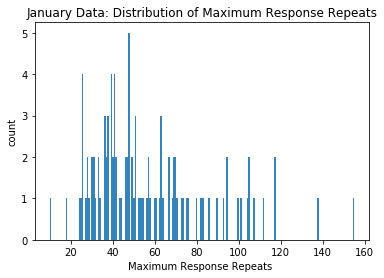

In [155]:
# Distribution of Maximum Response Repeats 

path = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_duration_MTurk/data'
day1 = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_duration_MTurk/day1'
day2 = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_duration_MTurk/day2'
old_data = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/january_data'

max_repeats = repeatResponses_Cleaning(path)[1]

plt.hist(max_repeats, bins=190, alpha=0.9)
plt.title('Distribution of Maximum Response Repeats')
plt.xlabel('Maximum Response Repeats ')
plt.ylabel('count')

plt.show()

Number of participants that had 60 or more repeated responses:  37


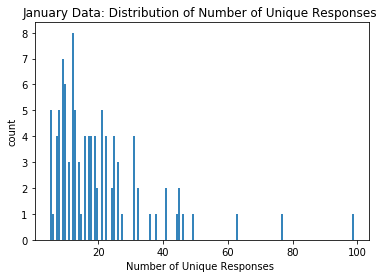

In [156]:
# Distribution of Number of Unique Responses 

unique_resp = repeatResponses_Cleaning(path)[2]

plt.hist(unique_resp, bins=150, alpha=0.9)
plt.title('Distribution of Number of Unique Responses ')
plt.xlabel('Number of Unique Responses ')
plt.ylabel('count')

plt.show()

When the rotated sequence jsons were created, the sequence names were not updated in the jsons which is why the unique sequence names are just a, b, c etc. The batch logs can be referenced to figure out which specific sequence was used by that participant. 

- unique completion code = subjID
- url (#num references the row of counterbalancing csv) 


In [180]:
path = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_duration_MTurk/data'

raw_data = removeIncorrectlyTaggedImageTrials(path)

print("Number of participants left: ", len(raw_data[0].subjID.unique()))

Number of participants that had 60 or more repeated responses:  30
Participants with 10% or more missed trials:  [950876, 193062, 965946, 988899, 379581, 432082, 329879]
Number of participants left:  156


In [ ]:

def durationDfs(datafolder):
    """
    Seperate the the data into seperate dataframes for each duration condition
    """
    
    cleaned_data = removeMissedTrials(datafolder)
    
    data_250ms = cleaned_data[cleaned_data['duration'] == 250.0]
    data_500ms = cleaned_data[cleaned_data['duration'] == 500.0]
    data_750ms = cleaned_data[cleaned_data['duration'] == 750.0]
    data_1000ms = cleaned_data[cleaned_data['duration'] == 1000.0]
    
    return [data_250ms, data_500ms, data_750ms, data_1000ms]

def roundActualDepth(datafolder):
    """
    Round Actual Depth value to nearest tenth
    - Actual depth values from the Kinect are very specific (ex. 3.128)
    - Need to round to calculate meaningful outlier params 
    """
    data = durationDfs(datafolder)
    
    for duration in data:
        for idx, row in duration.iterrows():
            actual_depth = row['actual_depth']
            rounded_depth = round(actual_depth,1) # round depth to the nearest tenth
            duration.at[idx,'actual_depth'] = rounded_depth      
        
    return data

def removeIncorrectlyTaggedImageTrials(datafolder):
    """
    Kinect depth tagging is incorrect 
    Not caught by previous effort to remove targets that are on the floor or wall 
    because the target is on a chair that is flush with the wall.
    
    """
    
    data = roundActualDepth(datafolder)
    
    remove_images = []
    for df in data:
        for index, row in df.iterrows():
            if row['stimulus'] in remove_images:
                df.drop(index, inplace=True)
    
    return data 

In [111]:
def getActualDepthAverage(data):
    """
    True average of target depths in the stimuli
    """
    df = pd.concat(data)
    
    avg_actual = np.mean(np.array(df['actual_depth']))
    
    return avg_actual

def participantAverageEstim_Cleaning(data):
    true_average = getActualDepthAverage(data)
    octave_window = [true_average/4, true_average * 4]
    print(true_average, octave_window)
    
    df = pd.concat(data)
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        # calculate subject's average depth estimation  
        avg = subj_df['depth_estimate'].mean()
        if avg < octave_window[0]:
            remove.append(subj)
        if avg > octave_window[1]:
            remove.append(subj)
    
    print("Avg Estim Cleaning: Number of Participants Removed", len(remove))
    
    for index, row in df.iterrows():
        if row['subjID'] in remove:
            df.drop(index, inplace=True)
    return df 



In [181]:
avg_estim_cleaned_data = participantAverageEstim_Cleaning(raw_data)

3.0249102850565373 [1.5124551425282686, 6.0498205701130745]
Avg Estim Cleaning: Number of Participants Removed 35


In [ ]:
# try to report as precisely as you can - you shouldnt find your self reporting the same depth estimate for many sequential trials 


# replace missing sequences 


In [182]:
rt_cleaned_data = RT_Cleaning(avg_estim_cleaned_data)

Number of Participants with 10% or more trials outside their RT range:  114


In [162]:
def finalTrialCountCheck(df):
    """
    If more then 10% of a participants data is missing, remove the participant
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        count_trials = subj_df.shape[0]
        threshold = math.floor(192 * 0.1)
        if count_trials >= threshold:
            remove.append(subj)
            
    print("Number of Participants with >= 10% trials removed: ", len(remove))
    
    for index, row in df.iterrows():
        if row['subjID'] in remove:
            df.drop(index, inplace=True)
        
    
    return df

In [183]:
percent_data_remaining_cleaned_data = finalTrialCountCheck(rt_cleaned_data)

Number of Participants with >= 10% trials removed:  121


In [191]:
percent_data_remaining_cleaned_data

,subjID,experimentName,versionName,sequenceName,url,selected_row,windowWidth,windowHeight,screenWidth,screenHeight,...,stimulus,duration,actual_depth,depth_estimate,trial_RT,log_sceneDuration,unitSelection,experimentTime,totalTime,age


In [194]:
def participant_Outlier_Removal(df):
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    df2_list = []
    remove = []
    count = 0
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        # calculate subject's average trial RT 
        average = subj_df["depth_estimate"].mean()
        std = subj_df["depth_estimate"].std()
        outlier_range = [(average - (3*std)), (average + (3*std))]
        
        low = subj_df.loc[subj_df['depth_estimate'] < outlier_range[0]]
        high = subj_df.loc[subj_df['depth_estimate'] > outlier_range[1]]
        count += len(low) + len(high)
        
        subj_df2 = subj_df.drop(subj_df.loc[subj_df['depth_estimate'] < outlier_range[0]].index)
        subj_df2 = subj_df.drop(subj_df.loc[subj_df['depth_estimate'] > outlier_range[1]].index)
        
        df2_list.append(subj_df2)
        threshold = math.floor(192 * 0.1)
        if count >= threshold:
            remove.append(subj)
    
    df2 = pd.concat(df2_list)
    
    print("Number of Participants with 10% or more outlier trials: ", len(remove))
    
    for index, row in df2.iterrows():
        if row['subjID'] in remove:
            df2.drop(index, inplace=True)
    
    return df2


In [192]:
cleaned_data = participant_Outlier_Removal(percent_data_remaining_cleaned_data)

### Normalize Data by Participant's Avg 

In [196]:
def normalize_dfs(data):
    """
    Args:
        cleaned data 
    Return:
        norm_data = list of duration dfs after data normalization by particpants average depth estimation
    """
    pd.options.mode.chained_assignment = None  # default='warn'

    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    norm_subjects = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]

        # calculate subject's average depth estimation 
        avg = subj_df['depth_estimate'].mean()

        # divide each depth estimate by the subject's average depth estimation 
        subj_df['depth_estimate'] = subj_df['depth_estimate'].apply(lambda x:x/avg)

        norm_subjects.append(subj_df)
    
    normalized_df = pd.concat(norm_subjects)
    
    # split into duration 
    data_250ms = normalized_df[normalized_df['duration'] == 250.0]
    data_500ms = normalized_df[normalized_df['duration'] == 500.0]
    data_750ms = normalized_df[normalized_df['duration'] == 750.0]
    data_1000ms = normalized_df[normalized_df['duration'] == 1000.0]
    
    return [data_250ms, data_500ms, data_750ms, data_1000ms]

In [ ]:
normalized_data = normalize_dfs(cleaned_data)

In [1]:
import os

c = 0
for file in os.listdir('/Users/prachi/Documents/depth_duration/analysis/data'):
    if '.csv' in file:
        c += 1
c

233